#Extraer datos mediante la API de inmobiliaria

pagina donde se hizo el webscraping: https://www.argenprop.com/

## Paises admitidos:
####Argentina, Chile, Uruguay, Brasil

ojo: brasil solo tiene 1 propiedad

## 0. Importamos las librerias:

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

## 1. Creamos la conexión con la API para extraer los datos

In [ ]:
# URL de la API con los parámetros incluidos
url = 'https://i004-reffindr-back-python.onrender.com/argenprop'

# Parámetros de la solicitud
params = {'pais': 'argentina', 'limite': 40}   # limite es el numero de inmuebles
response = requests.get(url, params=params)
data = response.json()
df = pd.DataFrame(data)

OJO : por el momento limite 40 no usar mas por que arroja error debido a que render no es de pago y gratuito solo tiene 0.1CPU y no se puede extraer mas datos, si les aparece error bajarle la cantidad de limite.

## 2. Transformación de datos

### Exploración Inicial
Identificar la estructura y calidad de nuestros datos de origen:

In [ ]:
df

,address,description,name,owner_id,price
0,"Las Casuarinas, Lujan, G.B.A. Zona Oeste","Antiguedad:15, Cant. Baños:2, Cant. Ambientes:...",ignacio agosti,298728_2,USD 1.300
1,"Mapuche Country Club, Countries y Barrios Cerr...","Antiguedad:35, Cant. Baños:4, Cant. Ambientes:...",VAL-JOR INMOBILIARIA,PRO-1115700,USD 1.950
2,"Nuestra Señora De Lourdes, Rosario, Departamen...","Antiguedad:90, Cant. Baños:2, Cant. Ambientes:...",Fares Bienes Raíces,260999-6288162,$ 2.300.000
3,"San Lorenzo, Salta Capital, Salta","Antiguedad:5, Cant. Baños:1, Cant. Ambientes:3...",daniel chilibertto,6EHK_1,$ 500.000
4,"El Canton - Norte, Countries y Barrios Cerrado...","Cant. Baños:2, Cant. Ambientes:5, Cant. Dormit...",Mansion Propiedades,PRO-1147558,USD 2.300
5,"La Horqueta, San Isidro, G.B.A. Zona Norte","Antiguedad:45, Cant. Baños:3, Cant. Dormitorio...",LOPEZ SAUBIDET PROPIEDADES,LSP2789,USD 3.200
6,"Golf, San Isidro, G.B.A. Zona Norte","Tipo de Unidad:Casa, Tipo de operación:Alquile...",JAUREGUIBERRY ASESORES INMOBILIARIOS,BC072341,USD 5.200
7,"Haras Del Pilar, Countries y Barrios Cerrados ...","Antiguedad:10, Cant. Baños:3, Cant. Ambientes:...",San Isidro Propiedades,63ZK_15,USD 1.700
8,"Villa Adelina, San Isidro, G.B.A. Zona Norte","Antiguedad:30, Cant. Baños:1, Cant. Dormitorio...",Daniel Gianferro,3OWE_2,$ 870.000
9,"Los Pilares, Countries y Barrios Cerrados en P...","Cant. Baños:2, Cant. Ambientes:5, Cant. Dormit...",Zulma Perez Estudio Inmobiliario,PRO-1153216,USD 1.200


In [ ]:
df.head()

,address,description,name,owner_id,price
0,"Las Casuarinas, Lujan, G.B.A. Zona Oeste","Antiguedad:15, Cant. Baños:2, Cant. Ambientes:...",ignacio agosti,298728_2,USD 1.300
1,"Mapuche Country Club, Countries y Barrios Cerr...","Antiguedad:35, Cant. Baños:4, Cant. Ambientes:...",VAL-JOR INMOBILIARIA,PRO-1115700,USD 1.950
2,"Nuestra Señora De Lourdes, Rosario, Departamen...","Antiguedad:90, Cant. Baños:2, Cant. Ambientes:...",Fares Bienes Raíces,260999-6288162,$ 2.300.000
3,"San Lorenzo, Salta Capital, Salta","Antiguedad:5, Cant. Baños:1, Cant. Ambientes:3...",daniel chilibertto,6EHK_1,$ 500.000
4,"El Canton - Norte, Countries y Barrios Cerrado...","Cant. Baños:2, Cant. Ambientes:5, Cant. Dormit...",Mansion Propiedades,PRO-1147558,USD 2.300


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   address      40 non-null     object
 1   description  40 non-null     object
 2   name         40 non-null     object
 3   owner_id     40 non-null     object
 4   price        40 non-null     object
dtypes: object(5)
memory usage: 1.7+ KB


Obtenemos un primer vistazo sobre nuestros datos y sus métricas

In [ ]:
df.describe().T

,count,unique,top,freq
address,40,37,"Fisherton, Rosario, Departamento de Rosario, S...",2
description,40,40,"Antiguedad:15, Cant. Baños:2, Cant. Ambientes:...",1
name,40,30,CRISTIAN CASTIGLIA PROPIEDADES,4
owner_id,40,40,298728_2,1
price,40,34,USD 2.300,3


Cantidad de filas y columnas:

In [ ]:
fila,col=df.shape

print(f"La cantidad de filas es de: {fila}")
print(f"La cantidad de columnas es de: {col}")

La cantidad de filas es de: 40
La cantidad de columnas es de: 5


Cantidad de valores nulos por columna:

In [ ]:
df.isnull().sum()

,0
address,0
description,0
name,0
owner_id,0
price,0


### Limpieza de datos
Eliminamos los registros duplicados en caso de que existan.

In [ ]:
df = df.drop_duplicates()

Eliminar columnas innecesarias

In [ ]:
df = df.drop(columns=['owner_id'])

Manejo de valores nulos (en este caso, eliminamos filas con valores nulos en caso de que existan)

In [ ]:
df = df.dropna()

Creamos una copia del dataframe

In [ ]:
df1=df.copy()

Limpieza de la columna price. Se pasan todos los valores a la misma unidad (USD)

In [ ]:
# Creamos una nueva columna con el precio en dolares para los que tienen USD en el precio (solo el numero, sin USD)
df1['price_usd'] = np.where(df1['price'].str.contains('USD'), df1['price'], np.nan)

# En la columna de precio en dolares dejamos solo el numero
df1['price_usd'] = df1['price_usd'].str.replace('USD ', '').str.replace('.','').astype(float)

# En la columna de precio eliminamos todos los precios que esten en dolares
df1['price'] = np.where(df1['price'].str.contains('USD'), np.nan, df1['price'])

# Convertimos los precios a dolares (1 USD = $ 1135) (solo 2 decimales)
df1['price'] = df1['price'].str.replace('$ ', '').str.replace('.','').astype(float)/1135
df1['price'] = df1['price'].round(2)

# Unimos las columnas de precio en dolares y precio
df1['price'] = df1['price'].fillna(df1['price_usd'])

# eliminar columna de precio en dolares
df1 = df1.drop(columns=['price_usd'])

Separar description en columnas individuales: Extrae información clave como antiguedad, cant_baños, cant_ambientes, etc., desde la columna description.

In [ ]:
df1['antiguedad'] = df1['description'].str.extract(r'Antiguedad:(\d+)').astype(float)
df1['cant_baños'] = df1['description'].str.extract(r'Cant. Baños:(\d+)').astype(float)
df1['cant_ambientes'] = df1['description'].str.extract(r'Cant. Ambientes:(\d+)').astype(float)
df1['cant_dormitorios'] = df1['description'].str.extract(r'Cant. Dormitorios:(\d+)').astype(float)
df1['cant_cocheras'] = df1['description'].str.extract(r'Cant. Cocheras:(\d+)').astype(float)
df1['cant_plantas'] = df1['description'].str.extract(r'Cant. Plantas:(\d+)').astype(float)
df1['estado'] = df1['description'].str.extract(r'Estado:(\w+\s?\w+)').astype(str)
df1['orientacion'] = df1['description'].str.extract(r'Orientación:(\w+)').astype(str)

Observamos algunas métricas para controlar

In [ ]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
price,40.0,1916.285750,1180.694888,440.53,1075.0,1642.95,2475.22,5200.0
antiguedad,25.0,24.480000,24.322692,1.00,10.0,20.00,30.00,100.0
cant_baños,36.0,3.027778,1.362479,1.00,2.0,3.00,4.00,7.0
cant_ambientes,33.0,5.303030,1.570924,2.00,5.0,5.00,6.00,10.0
cant_dormitorios,36.0,3.583333,0.967323,1.00,3.0,4.00,4.00,5.0
cant_cocheras,30.0,2.533333,1.634400,1.00,1.0,2.00,4.00,6.0
cant_plantas,32.0,1.968750,0.694883,1.00,2.0,2.00,2.00,4.0


completar valores faltantes con la media/moda de la columna según corresponda

In [ ]:
df1['antiguedad'] = df1['antiguedad'].fillna(df1['antiguedad'].mean())
df1['cant_baños'] = df1['cant_baños'].fillna(df1['cant_baños'].mean())
df1['cant_ambientes'] = df1['cant_ambientes'].fillna(df1['cant_ambientes'].mean())
df1['cant_dormitorios'] = df1['cant_dormitorios'].fillna(df1['cant_dormitorios'].mean())
df1['cant_cocheras'] = df1['cant_cocheras'].fillna(df1['cant_cocheras'].mean())
df1['cant_plantas'] = df1['cant_plantas'].fillna(df1['cant_plantas'].mean())
df1['estado'] = df1['estado'].fillna(df1['estado'].mode()[0]) # completar con el valor mas frecuente
df1['orientacion'] = df1['orientacion'].fillna(df1['orientacion'].mode()[0])

In [ ]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
price,40.0,1916.285750,1180.694888,440.53,1075.00000,1642.950000,2475.22,5200.0
antiguedad,40.0,24.480000,19.080289,1.00,15.00000,24.480000,24.48,100.0
cant_baños,40.0,3.027778,1.290719,1.00,2.00000,3.000000,4.00,7.0
cant_ambientes,40.0,5.303030,1.422977,2.00,5.00000,5.000000,6.00,10.0
cant_dormitorios,40.0,3.583333,0.916375,1.00,3.00000,4.000000,4.00,5.0
cant_cocheras,40.0,2.533333,1.409370,1.00,1.00000,2.533333,3.00,6.0
cant_plantas,40.0,1.968750,0.619527,1.00,1.96875,2.000000,2.00,4.0


Convertimos los valores a enteros

In [ ]:
df1['antiguedad'] = df1['antiguedad'].astype(int)
df1['cant_baños'] = df1['cant_baños'].astype(int)
df1['cant_ambientes'] = df1['cant_ambientes'].astype(int)
df1['cant_dormitorios'] = df1['cant_dormitorios'].astype(int)
df1['cant_cocheras'] = df1['cant_cocheras'].astype(int)
df1['cant_plantas'] = df1['cant_plantas'].astype(int)

Eliminamos la columna description

In [ ]:
df1 = df1.drop(columns=['description'])

Función para dividir y procesar las direcciones en columnas individuales

In [ ]:
def process_address(address):
    parts = address.split(",")
    parts = [p.strip() for p in parts]  # Eliminar espacios adicionales

    # Llenar con 'nulo' según el número de partes
    if len(parts) == 4:
        return parts
    elif len(parts) == 3:
        return ['nulo'] + parts  # Si hay 3 partes, el primer valor es nulo (calle_lugar)
    elif len(parts) == 2:
        return parts + ['nulo', 'nulo']  # Si hay 2 partes, solo se tienen calle_lugar y barrio

# Aplicar la función a la columna 'address'
direcciones = df1['address'].apply(process_address)

# Crear un nuevo DataFrame con las columnas específicas
columns = ['calle_lugar', 'barrio', 'localidad', 'provincia_zona']
result = pd.DataFrame(direcciones.tolist(), columns=columns)

# reemplazar los valores "nulo" por NaN
result = result.replace('nulo', np.nan)

# agregar las columnas al dataframe original
df1 = pd.concat([df1, result], axis=1)

# eliminar la columna address
df1 = df1.drop(columns=['address'])

### Creación de Nuevas Columnas - Enriquecimiento de Datos
Categorizar precios: Crea una nueva columna para clasificar las propiedades según el precio

In [ ]:
def categorize_price(price):
    if price < 1000:
        return 'Bajo'
    elif price < 3000:
        return 'Medio'
    else:
        return 'Alto'

df1['price_category'] = df1['price'].apply(categorize_price)

In [ ]:
# Verificación rápida de cómo se han clasificado los precios:
print(df1[['price', 'price_category']].head(10))

     price price_category
0  1300.00          Medio
1  1950.00          Medio
2  2026.43          Medio
3   440.53           Bajo
4  2300.00          Medio
5  3200.00           Alto
6  5200.00           Alto
7  1700.00          Medio
8   766.52           Bajo
9  1200.00          Medio


Conteo del número de elementos en cada categoría y así poder ver la distribución de las categorías:

In [ ]:
print(df1['price_category'].value_counts())

price_category
Medio    26
Bajo      9
Alto      5
Name: count, dtype: int64


Obtención de estadísticas por categorías:

In [ ]:
print(df1.groupby('price_category')['price'].describe())

                count         mean         std      min        25%      50%  \
price_category                                                                
Alto              5.0  4379.800000  807.582937  3200.00  3999.0000  4500.00   
Bajo              9.0   723.714444  163.967150   440.53   616.7400   766.52   
Medio            26.0  1855.346154  576.285694  1000.00  1305.3975  1875.00   

                   75%      max  
price_category                   
Alto            5000.0  5200.00  
Bajo             837.0   969.16  
Medio           2300.0  2900.00  


Cambiar nombre a columna price por price_usd

In [ ]:
df1.rename(columns={'price': 'price_usd'}, inplace=True)

Visualización de un gráfico de distribución simple:

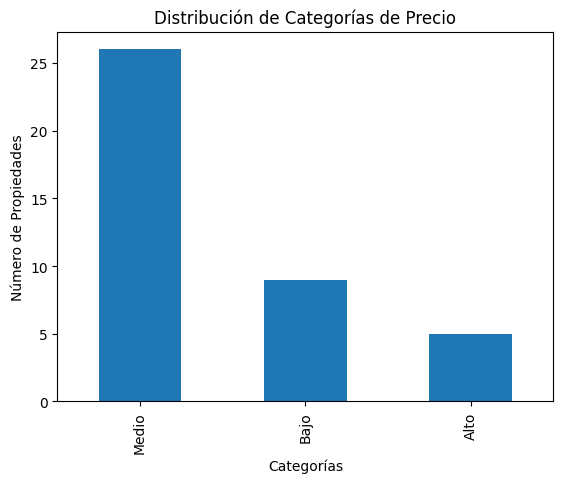

In [ ]:
df1['price_category'].value_counts().plot(kind='bar')
plt.title('Distribución de Categorías de Precio')
plt.xlabel('Categorías')
plt.ylabel('Número de Propiedades')
plt.show()

Agrega columnas para análisis adicionales, como la fecha de extracción:

In [ ]:
df1['Extraction_Date'] = datetime.now().strftime('%Y-%m-%d')
print(df1[['Extraction_Date']].head(10))

  Extraction_Date
0      2024-11-23
1      2024-11-23
2      2024-11-23
3      2024-11-23
4      2024-11-23
5      2024-11-23
6      2024-11-23
7      2024-11-23
8      2024-11-23
9      2024-11-23


### Interesante a añadir: Agregar una columna de ubicación geográfica: Si contamos con un servicio de geocodificación, podríamos usar la columna address para obtener las coordenadas (latitud y longitud).

# 3. Validación de Datos
Revisar valores nulos: Proceso de verificación si hay valores faltantes en las columnas importantes y toma de decisiones de cómo manejarlos.

In [ ]:
print(df1.isnull().sum())

name                 0
price_usd            0
antiguedad           0
cant_baños           0
cant_ambientes       0
cant_dormitorios     0
cant_cocheras        0
cant_plantas         0
estado               0
orientacion          0
calle_lugar         10
barrio               0
localidad            7
provincia_zona       7
price_category       0
Extraction_Date      0
dtype: int64


Estandarización de nombres: Para realizar análisis posteriores, es mejor estandarizar los nombres de las columnas a minúsculas y sin espacios.

In [ ]:
df1.columns = df1.columns.str.lower().str.replace(' ', '_')

## 4. Carga de datos

Guarda los datos limpios y transformados en un formato que permita un análisis posterior.

Guarda los Datos en Google Drive o Localmente, hasta que tengamos la base de datos operativa.

Exporta los datos como archivo CSV o Excel

In [ ]:
df1.to_csv('properties_df.csv', index=False)

## 5. Análisis y Conclusiones

Análisis exploratorio y visualizaciones de datos.

Uso de bibliotecas como matplotlib o seaborn para crear gráficos con los que ayudarnos a extraer conclusiones:

Histograma de precios

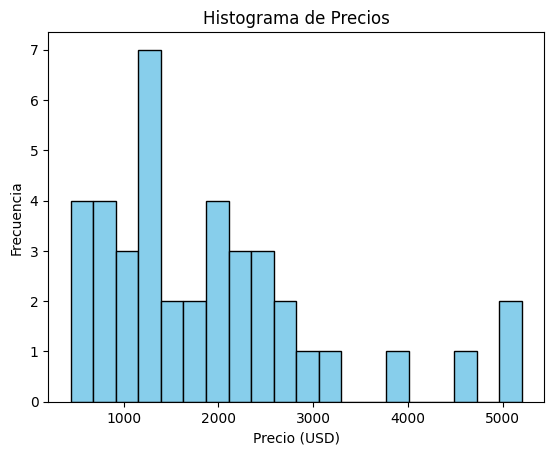

In [ ]:
df1['price_usd'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title('Histograma de Precios')
plt.xlabel('Precio (USD)')
plt.ylabel('Frecuencia')
plt.show()


Boxplot de precios por categoría

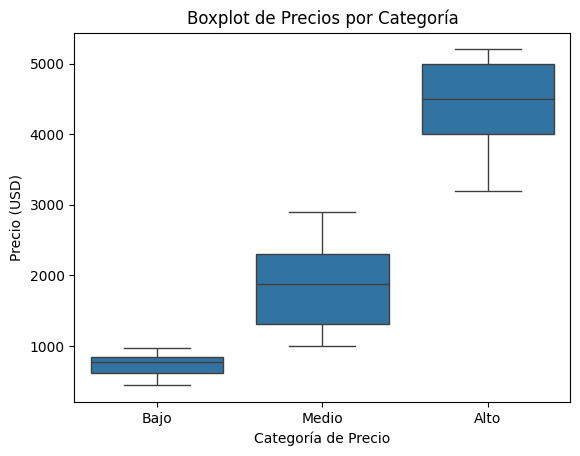

In [ ]:
sns.boxplot(x='price_category', y='price_usd', data=df1, order=['Bajo', 'Medio', 'Alto'])
plt.title('Boxplot de Precios por Categoría')
plt.xlabel('Categoría de Precio')
plt.ylabel('Precio (USD)')
plt.show()


Matriz de correlación

In [ ]:
#solo para las columnas de tipo numerico
numeric_df = df1.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()
